In [1]:
import mxnet as mx
from mxnet import gluon, autograd
from mxnet import ndarray as nd
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import vision as models
import numpy as np
from PIL import Image
import os

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import json
imagenet_classes = json.load(open('imagenet_classes.json'))
idx2class = [imagenet_classes[str(i)].split(',')[0] for i in range(1000)]
class2idx = {v:i for i,v in enumerate(idx2class)}

In [4]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (classifier): HybridSequential(
    (0): Dense(4096, Activation(relu))
    (1): Dropout(p = 0.5)
    (2): Dense(4096, Activation(relu))
    (3): Dropout(p = 0.5)
    (4): Dense(1000, linear)
  )
  (features): HybridSequential(
    (0): Conv2D(64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Activation(relu)
    (2): Conv2D(64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Activation(relu)
    (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (5): Conv2D(128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Activation(relu)
    (7): Conv2D(128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Activation(relu)
    (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (10): Conv2D(256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Activation(relu)
    (12): Conv2D(256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Activation(relu)
    (14): Conv2D

In [5]:
def np_softmax(x):
    e = np.exp(x)
    probs = e/np.sum(e)
    return probs

In [6]:
def transform(data):
    data = nd.array(img_array)
    data = mx.image.imresize(data, 256, 256)
    data, _ = mx.image.center_crop(data, (224, 224))
    data = nd.transpose(data, (2, 0, 1))
    data = data.astype(np.float32)/127.5 - 1
    data = data.reshape((1,)+data.shape)
    return data

In [7]:
img_array = np.asarray(Image.open('espresso.png'))
data = transform(img_array)
print(data.shape)

(1, 3, 224, 224)


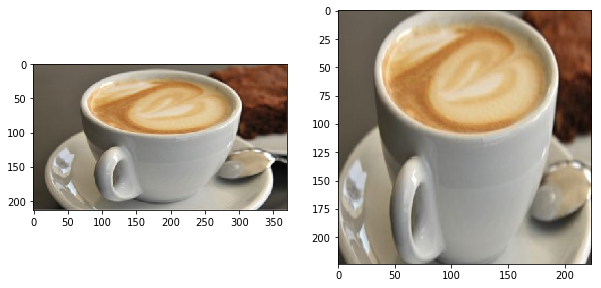

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_array)
plt.subplot(1,2,2)
plt.imshow(((data[0].asnumpy().transpose(1,2,0)+1)*127.5).astype(np.uint8))

In [9]:
data.attach_grad()
with autograd.record():
    out = vgg16(data)
    out[0,class2idx['nematode']].backward()
print(out.asnumpy().shape)
probs = np_softmax(out.asnumpy())
cls_idx = np.argmax(out.asnumpy())
print(str(cls_idx) + ":" + idx2class[cls_idx] + ":" + str(out.asnumpy()[0][cls_idx]) + ":" + str(probs[0][cls_idx]))

(1, 1000)
967:espresso:22.3187:0.991349


504:coffee mug:0.684324


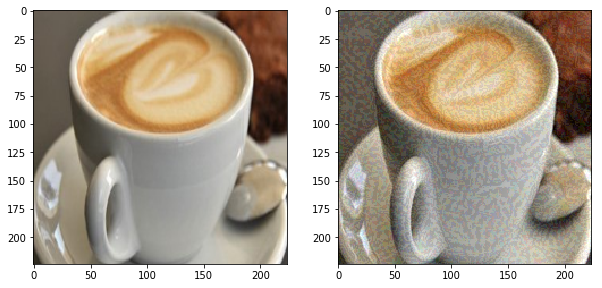

In [10]:
grad_sign = nd.sign(data.grad)
epsilon = 10
new_data = ((data+1)*127.5+epsilon*grad_sign).asnumpy()
new_data[new_data>255] = 255
new_data[new_data<0] = 0
new_data = new_data.astype(np.uint8)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(((data[0].asnumpy().transpose(1,2,0)+1)*127.5).astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow(new_data[0].transpose(1,2,0))
new_data = nd.array(new_data.astype(np.float32)/127.5-1)
new_out = vgg16(new_data)
new_probs = np_softmax(new_out.asnumpy())
new_cls_idx = np.argmax(new_probs)
print(str(new_cls_idx) + ":" + idx2class[new_cls_idx] + ":" + str(new_probs[0][new_cls_idx]))

### Iterative change (from CS231n)

In [19]:
learning_rate = 1
img_array = np.asarray(Image.open('espresso.png'))
fake_data = transform(img_array)
fake_class_idx = class2idx['nematode']
fake_data.attach_grad()
for i in range(100):
    with autograd.record():
        out_fake = vgg16(fake_data)
        out_idx = np.argmax(out_fake.asnumpy()[0])
        if out_idx == fake_class_idx:
            print('Fake generated in ' + str(i) + ' iterations')
            break
        out_fake[0,fake_class_idx].backward()
    fake_data_grad = fake_data.grad
    fake_data += learning_rate*fake_data_grad/mx.nd.norm(fake_data_grad)
probs_fake = np_softmax(out_fake.asnumpy())
print(str(fake_class_idx) + ":" + idx2class[fake_class_idx] + ":" + str(out_fake.asnumpy()[0][fake_class_idx]) + ":" + str(probs_fake[0][fake_class_idx]))

Fake generated in 5 iterations
111:nematode:34.5579:0.944211


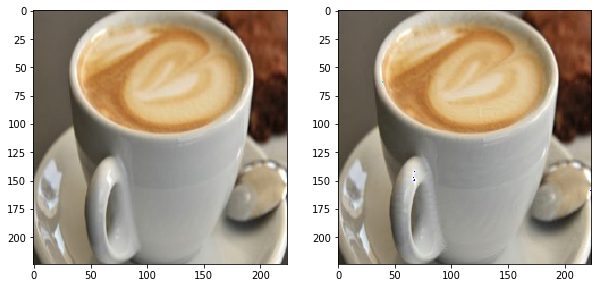

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(((data[0].asnumpy().transpose(1,2,0)+1)*127.5).astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow(((fake_data.asnumpy()+1)*127.5).astype(np.uint8)[0].transpose(1,2,0))